In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
hn = 3
class Model(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.stepLength = 1.2
        self.hidden = torch.zeros((1, hn))
        
        self.Whh = nn.Linear(hn, hn)
        self.Whx = nn.Linear(1, hn, bias = False)
        
        self.layer1 = nn.Linear(1 + hn, 32)
        self.layer2 = nn.Linear(32, 8)
        self.layer3 = nn.Linear(8, 1)
      
    
    def forward_RNN(self, x):
        self.hidden = torch.tanh(self.Whh(self.hidden) + self.Whx(x))
        
        
    def forward_DNN(self, x):
        
        y = torch.cat((self.hidden.repeat(x.shape[0], 1), x), 1)
        
        y = torch.tanh(self.layer1(y))
        y = torch.tanh(self.layer2(y))
        y = self.layer3(y)
     
        return y*torch.exp(-0.1*x**2)
    
    def sample(self):
        total = 0
        x = torch.Tensor(4*np.random.random((1,1)) - 2)
        psi_old = self.forward_DNN(x)
        
        for i in range(20):
            x_new = x + 1.5*torch.Tensor(2*np.random.random((1,1)) - 1)
            psi_new = self.forward_DNN(x_new)
            
            if (psi_new/psi_old)**2 > np.random.random():
                x = x_new
                psi_old = psi_new
                total += 1
            
        return x, total
    
    def resetHidden(self):
        self.hidden = torch.zeros((1, hn))
        self.forward_RNN(torch.zeros((1, 1)))
        

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
model = Model()
optimizer = torch.optim.Adam(model.parameters())

### Using naive minimization of energy

In [ ]:
epochs = 1000
N = 500
for epoch in tqdm(range(epochs)):
    PE_acc = 0
    P_acc = 0
    E_acc = 0
    grad = 0
    
    for i in range(N):
        psi_total = 1
        
        model.resetHidden() 
        x1 = model.sample()[0].detach().requires_grad_()
        psi1 = model.forward_DNN(x1)
        
        model.forward_RNN(x1)
        x2 = model.sample()[0].detach().requires_grad_()
        psi2 = model.forward_DNN(x2)
        
        psi_total = psi1*psi2
        dfdx, = torch.autograd.grad(psi_total, x1, create_graph=True)
        d2fdx2, = torch.autograd.grad(dfdx, x1, create_graph=True)
        
        kinetic1 = -0.5*d2fdx2/psi_total
        potential1 = 0.5*x1**2
        
        dfdx, = torch.autograd.grad(psi_total, x2, create_graph=True)
        d2fdx2, = torch.autograd.grad(dfdx, x2, create_graph=True)
        
        kinetic2 = -0.5*d2fdx2/psi_total
        potential2 = 0.5*x2**2
        
        E_L = (kinetic1 + potential1 + kinetic2 + potential2 + 0.5/torch.abs(x1-x2)).detach()
        PE_acc += psi_total/psi_total.detach()*E_L
        P_acc  += psi_total/psi_total.detach()
        E_acc  += E_L   
    
    PE_acc /= N
    P_acc  /= N
    E_acc  /= N
    
    E = 2*(PE_acc - P_acc*E_acc)
    
    optimizer.zero_grad()
    E.backward()
    optimizer.step()
    
    for param in model.parameters():
            grad += torch.sum(param.grad**2)

    
    if (epoch%10 == 0):
        print(f"epoch: {epoch}, Grad: {grad}, Energy: {E_acc.item()}")

  0%|          | 1/1000 [00:04<1:09:38,  4.18s/it]

epoch: 0, Grad: 35.453102111816406, Energy: 6.833164691925049


  1%|          | 11/1000 [00:46<1:09:07,  4.19s/it]

epoch: 10, Grad: 10.343284606933594, Energy: 4.271621227264404


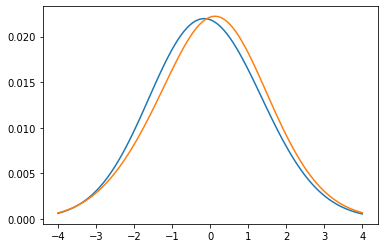

In [49]:
x_lin = torch.linspace(-4, 4, 100).reshape(100,-1)
model.resetHidden()
psi1 = model.forward_DNN(x_lin)[:,0].detach().numpy()

model.forward_RNN(torch.Tensor([[0]]))
psi2 = model.forward_DNN(x_lin)[:,0].detach().numpy()

plt.plot(x_lin[:,0], psi1**2/np.sum(psi1**2))
plt.plot(x_lin[:,0], psi2**2/np.sum(psi2**2))

plt.show()

In [ ]:
x_lin = torch.linspace(-4, 4, 100).reshape(100,-1)
psi = model.forward(x_lin)[:,0].detach().numpy()

plt.plot(x_lin[:,0], psi**2)
plt.plot(x_lin[:,0], 1/np.sqrt(np.pi)*np.exp(-x_lin[:,0]**2), "--")
plt.legend(["DNN", "analytical"])
plt.show()


## Estimating energy

In [45]:
N = 10000

E = 0
for i in tqdm(range(N)):
    model.resetHidden() 
    x1 = model.sample()[0].detach().requires_grad_()
    psi1 = model.forward_DNN(x1)

    model.forward_RNN(x1)
    x2 = model.sample()[0].detach().requires_grad_()
    psi2 = model.forward_DNN(x2)

    psi_total = psi1*psi2
    dfdx, = torch.autograd.grad(psi_total, x1, create_graph=True)
    d2fdx2, = torch.autograd.grad(dfdx, x1, create_graph=True)

    kinetic1 = -0.5*d2fdx2/psi_total
    potential1 = 0.5*x1**2

    dfdx, = torch.autograd.grad(psi_total, x2, create_graph=True)
    d2fdx2, = torch.autograd.grad(dfdx, x2, create_graph=True)

    kinetic2 = -0.5*d2fdx2/psi_total
    potential2 = 0.5*x2**2

    E += (kinetic1 + potential1 + kinetic2 + potential2 + 0.5/torch.abs(x1-x2)).detach()

E = E/N

print(E.item())

100%|██████████| 10000/10000 [01:19<00:00, 125.42it/s]

4.417324066162109


In [36]:
model.sample()

(tensor([[-1.7836]]), 14)

### Added penalization of small amplitude

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
model = Model()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
epochs = 200
N = 50
mu = 0.5
for epoch in tqdm(range(epochs)):
    PE_acc = 0
    P_acc = 0
    E_acc = 0
    grad = 0
    psi_pen = 0
    
    for i in range(N):
        x = model.sample()[0].detach().requires_grad_()
     
        psi = model.forward(x)
        psi_pen += (1 - psi**2)**2
        dfdx, = torch.autograd.grad(psi, x, create_graph=True)
        d2fdx2, = torch.autograd.grad(dfdx, x, create_graph=True)
        
        kinetic = -0.5*d2fdx2/psi
        potential = 0.5*x**2
        
        E_L = (kinetic + potential).detach()
        PE_acc += psi/psi.detach()*E_L
        P_acc  += psi/psi.detach()
        E_acc  += E_L   
    
    PE_acc /= N
    P_acc  /= N
    E_acc  /= N
    psi_pen /= N
    
    E = 2*(PE_acc - P_acc*E_acc) + mu*psi_pen
    
    optimizer.zero_grad()
    E.backward()
    optimizer.step()
    
    for param in model.parameters():
            grad += torch.sum(param.grad**2)

    
    if (epoch%10 == 0):
        print(f"epoch: {epoch}, Grad: {grad}, Energy: {E_acc.item()}")

## Testing auto grad

In [ ]:
x = torch.Tensor([-2]).requires_grad_()

psi = model.forward(x)
dfdx, = torch.autograd.grad(psi, x, create_graph=True)
d2fdx2, = torch.autograd.grad(dfdx, x, create_graph=True)
print(d2fdx2)

x = torch.Tensor([3]).requires_grad_()
y = torch.Tensor([4]).requires_grad_()

f = x**3*y**2

#f.backward()
#print(x.grad, y.grad)

dfdx, = torch.autograd.grad(f, x, create_graph=True)
d2fdx2, = torch.autograd.grad(dfdx, x, create_graph=True)

print(d2fdx2)

d2fdx2.backward()
print(x.grad, y.grad)

#print(dfdx)


#ddfdxdx, = torch.autograd.grad(dfdx, x, create_graph=True)
#print(ddfdxdx.grad_fn(x)[1])